In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import peakutils
import matplotlib.pyplot as plt
import scipy.signal as sg
from scipy.signal import welch, butter, freqz, lfilter
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array, isnan, argwhere, argmax, argmin, fft, absolute
from statistics import mean, stdev, variance
from scipy.stats import kurtosis, skew
from sklearn import neighbors, preprocessing, svm

%matplotlib inline

In [2]:
subject_file_names = ["ID001","ID002","ID003","ID004","ID005",
                     "ID006","ID007","ID008","ID009","ID010",
                     "ID011","ID012","ID013","ID014","ID015",
                    "ID016","ID017","ID018","ID019","ID020"]

label_map = {"ID001": 1,"ID002": 2,"ID003": 3,"ID004": 4,"ID005": 5,
            "ID006": 6,"ID007":7,"ID008":8,"ID009":9,"ID010":10,
            "ID011":11,"ID012":12,"ID013":13,"ID014":14,"ID015":15,
            "ID016":16,"ID017":17,"ID018":18,"ID019":19,"ID020":20}

label_dict = {1:"ID001",2:"ID002",3:"ID003",4:"ID004",5:"ID005",
             6:"ID006",7:"ID007",8:"ID008",9:"ID009",10:"ID010",
             11:"ID011",12:"ID012",13:"ID013",14:"ID014",15:"ID015",
            16:"ID016",17:"ID017",18:"ID018",19:"ID019",20:"ID020"}

threshold = []
threshold_value = 0
for i in range (51):
    threshold.append(threshold_value)
    threshold_value += 2
print(threshold)

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]


In [3]:
acc_f = open("Results/accelerometer_enrollment.csv","w+")
gyr_f = open("Results/gyroscope_enrollment.csv","w+")

In [4]:
class Feature_Vector: 
    def __init__(self, max_amplitude, min_amplitude, mean, variance,  kurtosis,
        skewness, ptp_time, alar, energy):
        self.max_amplitude = max_amplitude
        self.min_amplitude = min_amplitude
        self.mean = mean
        self.variance = variance
        self.kurtosis = kurtosis
        self.skewness = skewness
        self.ptp_time = ptp_time
        self.alar = alar
        self.energy = energy
        
    def toCSV(self):
        return(','.join([str(i) for i in [self.max_amplitude,self.min_amplitude,self.mean,
                                    self.variance,self.kurtosis,self.skewness,
                                    self.ptp_time,self.alar,self.energy]]))

In [5]:
def signal_preprocessing(filename, sfn, command, feature_vector_list=None):
    list = []
    
    df_gait_file = pd.read_csv(filename, index_col="time").iloc[100:-100]
    df_gait_file.index *= 0.001

    #calculate magnitude
    df_gait_file["magnitude"] = np.sqrt(np.square(df_gait_file).sum(axis=1))
    
    #Interpolate the data using a cubic spline
    df_gait_file_spline = df_gait_file.reindex(np.arange(df_gait_file.index[0], df_gait_file.index[-1], 0.005), method="nearest", tolerance=0.002)
    df_gait_file_spline = df_gait_file_spline.interpolate(method="cubic").dropna()
    
    #Buterworth filter 
    def butter_lowpass(cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=5):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        return y

    # Filter requirements.
    order = 5
    fs = 200.0       # sample rate, Hz
    cutoff = 3  # desired cutoff frequency of the filter, Hz

    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)
    
    df_gait_file_spline["filtered"] = butter_lowpass_filter(df_gait_file_spline["magnitude"], cutoff, fs, order)
    filtered = butter_lowpass_filter(df_gait_file_spline["magnitude"], cutoff, fs, order)

    col1 = df_gait_file_spline.index # First column data
    col2 = array(df_gait_file_spline["filtered"]) # Second column data
    
    #Optimal Threshold filter
    def find_optimal_threshold(t_low=0.2, t_high=1.0):
        """
        Finds the threshold as the one which minimises the standard deviation of the difference between peaks
        (normalised to the smallest value). 
        """
        optimal_threshold = 0.65
        closest_stdev = 10000.0
        for threshold in arange(t_low, t_high, 0.01):
            index = peakutils.indexes(-col2, thres=threshold, min_dist=20)
            index_diff = [index[i+1] - index[i] for i in range(len(index) - 1)]
            index_diff_norm = [float(idx)/min(index_diff) for idx in index_diff]
            if len(index_diff_norm) < 5:
                continue
            test_stdev = stdev(index_diff_norm)
            if test_stdev < closest_stdev:
                closest_stdev = test_stdev
                optimal_threshold = threshold
        return optimal_threshold
   
    thres = find_optimal_threshold()
    #print ("Optimal threshold = %s" % thres)
    index = peakutils.indexes(-col2, thres=thres, min_dist=80)
    #print('Peaks are: %s' % (index))
    
    index_diff = [index[i+1] - index[i] for i in range(len(index) - 1)]
    seg_mean, seg_stdev = mean(index_diff), stdev(index_diff)
    #print (seg_mean, seg_stdev)

    traces = []
    for i in range(len(index) - 1):
        if abs(index_diff[i] - seg_mean) > seg_stdev:
            continue
        traces.append(array(df_gait_file_spline["filtered"].iloc[index[i]:index[i+1]]))
        
    longest_trace_length = max([len(t) for t in traces])

    average_trace = []
    stdev_trace = []

    for i in range(longest_trace_length):
        vals = []
        for t in traces:
            try:
                vals.append(t[i])
            except IndexError:
                pass
        average_trace.append(mean(vals))
        try:
            stdev_trace.append(stdev(vals))
        except:
            stdev_trace.append(0.0)

    average_trace = array(average_trace)
    stdev_trace = array(stdev_trace)

    #Print features for all traces     
    if command == "append to accelerometer training file":
        for t in traces:
            A_k = fft.fft(t, 64)
            data = (','.join([str(i) for i in [max(t), min(t), mean(t), variance(t), kurtosis(t), skew(t), argmax(t)*0.005 + argmin(t)*0.005, argmax(t)*0.005/max(t), sum(absolute(A_k)**2)/len(A_k)]]))
            with open("Results/accelerometer_enrollment.csv","a+") as acc_f:
                    acc_f.write(data + "," + sfn + "\n")
                    acc_f.close()
    if command == "append to gyroscope training file":
        for t in traces:
            A_k = fft.fft(t, 64)
            data = (','.join([str(i) for i in [max(t), min(t), mean(t), variance(t), kurtosis(t), skew(t), argmax(t)*0.005 + argmin(t)*0.005, argmax(t)*0.005/max(t), sum(absolute(A_k)**2)/len(A_k)]]))
            with open("Results/gyroscope_enrollment.csv","a+") as gyr_f:
                gyr_f.write(data + "," + sfn + "\n")
                gyr_f.close()
                
    if command == "populate accelerometer fv list":
        for t in traces:
            A_k = fft.fft(t, 64)
            feature_vector_list.append(Feature_Vector(max(t), min(t), mean(t), variance(t), kurtosis(t), skew(t), argmax(t)*0.005 + argmin(t)*0.005, argmax(t)*0.005/max(t), sum(absolute(A_k)**2)/len(A_k)))
        
    if command == "populate gyroscope fv list":
        for t in traces:
            A_k = fft.fft(t, 64)
            feature_vector_list.append(Feature_Vector(max(t), min(t), mean(t), variance(t), kurtosis(t), skew(t), argmax(t)*0.005 + argmin(t)*0.005, argmax(t)*0.005/max(t), sum(absolute(A_k)**2)/len(A_k)))

In [6]:
#Enrollment process

for sfn in subject_file_names:
    signal_preprocessing("UJGaitDataset/accTrain/" + sfn + "-accelerometer01.csv", sfn, "append to accelerometer training file")
    signal_preprocessing("UJGaitDataset/gyrTrain/" + sfn + "-gyroscope01.csv", sfn, "append to gyroscope training file")


In [7]:
def classification_task(sensor, preprocessed_sample, list_for_results):
    
    classification_data = pd.read_csv("Results/" + sensor + "_enrollment.csv", 
                                      names=["a_max_amplitude", "a_min_amplitude", "a_mean",
                                              "a_variance","a_kurtosis","a_skewness","a_pp_time",
                                              "a_alar", "a_energy","label"])
    classification_data["logical_label"] = classification_data["label"].dropna().apply(lambda x: label_map[x])
    X = np.transpose(np.vstack((np.array(classification_data["a_max_amplitude"]), np.array(classification_data["a_min_amplitude"]),
                            np.array(classification_data["a_mean"]), np.array(classification_data["a_variance"]),
                           np.array(classification_data["a_kurtosis"]), np.array(classification_data["a_skewness"]),
                           np.array(classification_data["a_pp_time"]), np.array(classification_data["a_alar"]),
                           np.array(classification_data["a_energy"]))))

    X_scaled = preprocessing.scale(X)
    means = X.mean(axis=0)
    stdevs = X.std(axis=0)
    Y = np.hstack(np.array(classification_data["logical_label"]))
    means, stdevs

    knn=neighbors.KNeighborsClassifier()
    knn.fit(X_scaled, Y)
    
    test = preprocessed_sample
    #results = list(map(int, results))
    test_array = test.split(",")
    test_array = list(map(float, test_array))
    scaled_test_array = (test_array - means)/stdevs
    #print(knn.predict([scaled_test_array])[0])
    list_for_results.append(knn.predict([scaled_test_array])[0])

In [8]:
def classify(sfn, acc_score_list, gyr_score_list):
    acc_feature_vector_list = []
    gyr_feature_vector_list = []
    
    signal_preprocessing("UJGaitDataset/accTest/" + sfn + "-accelerometer02.csv", sfn, "populate accelerometer fv list", acc_feature_vector_list)
    signal_preprocessing("UJGaitDataset/gyrTest/" + sfn + "-gyroscope02.csv", sfn, "populate gyroscope fv list", gyr_feature_vector_list)
    
    for a in range(len(acc_feature_vector_list) - 1):
        classification_task("accelerometer", acc_feature_vector_list[a].toCSV(), acc_score_list)
    for g in range(len(gyr_feature_vector_list) - 1):
        classification_task("gyroscope", gyr_feature_vector_list[g].toCSV(), gyr_score_list)
    


In [11]:
import operator
from sklearn.metrics import roc_curve

def results(sfn, acc_score_list, gyr_score_list, tpr, fpr, pass_percentage, threshold_index):
    
    authenticated = False
    valid_access_control_decision = False
    weighted_percentage = 0.0
    
    print("\nACCELEROMETER CLASSIFICATION RESULTS")

    a_dict = {}
    for a in acc_score_list:
        if label_dict[a] in a_dict:
            a_dict[label_dict[a]] += 1
        else:
            a_dict[label_dict[a]] = 1
    #print(a_dict)
    for key, value in a_dict.items():
        print(str(round(value*100/len(acc_score_list),1)) + "% - " + key)
    
    print("\nGYROSCOPE CLASSIFICATION RESULTS")
    g_dict = {}
    for g in gyr_score_list:
        if label_dict[g] in g_dict:
            g_dict[label_dict[g]] += 1
        else:
            g_dict[label_dict[g]] = 1
    #print(g_dict)        
    for key, value in g_dict.items():
        print(str(round(value*100/len(gyr_score_list),1)) + "% - " + key)
        
    a_max = max(a_dict.items(), key=operator.itemgetter(1))[0]
    g_max = max(g_dict.items(), key=operator.itemgetter(1))[0]
    
    #print("\n")
    #print("a max: " + a_max + " g max: " + g_max)
    
    if a_max == g_max:
        weighted_percentage = (5.5 * ((a_dict[a_max] * 100)/len(acc_score_list)) + 4.5 * ((g_dict[g_max] * 100)/len(gyr_score_list)))/10
        print("weighted_percentage: " + str(round(weighted_percentage,2)) + "%")
        if weighted_percentage >= pass_percentage:
            authenticated = True
    else:
        weighted_percentage = (a_dict[a_max]*100/len(acc_score_list))
        print("weighted_percentage: " + str(round(weighted_percentage,2)) + "%")

        if weighted_percentage > 80 or weighted_percentage >= pass_percentage + 15:
            authenticated = True

    print("\n")        
    print(a_max + " authentication status: " + str(authenticated))
    
    if sfn == a_max:
        valid_access_control_decision = True
    
    print("Valid access control: " + str(valid_access_control_decision))
  
    #FAR++
    if authenticated is True and valid_access_control_decision is False:
        fpr[c] += 1       
    if authenticated is True and valid_access_control_decision is True:
        tpr[c] += 1        

    #print(fpr)  
    #print(tpr)

In [12]:
tpr = np.zeros(len(threshold))
fpr = np.zeros(len(threshold))

for c in range(len(threshold) - 1):
    print("******************************************* Threshold: " + str(threshold[c]) + "% *************************************")
    for sfn in subject_file_names:
        acc_score_list = []
        gyr_score_list = []
        
        print("\n" + sfn + " - Classification")
        classify(sfn, acc_score_list, gyr_score_list)
        results(sfn, acc_score_list, gyr_score_list, tpr, fpr, threshold[c], c)

******************************************* Threshold: 0% *************************************

ID001 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
75.0% - ID005
25.0% - ID002

GYROSCOPE CLASSIFICATION RESULTS
18.2% - ID014
72.7% - ID001
4.5% - ID017
4.5% - ID004
weighted_percentage: 75.0%


ID005 authentication status: True
Valid access control: False

ID002 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
73.9% - ID002
13.0% - ID009
13.0% - ID019

GYROSCOPE CLASSIFICATION RESULTS
9.1% - ID010
18.2% - ID015
9.1% - ID006
27.3% - ID011
9.1% - ID014
9.1% - ID020
9.1% - ID012
9.1% - ID018
weighted_percentage: 73.91%


ID002 authentication status: True
Valid access control: True

ID003 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
33.3% - ID003
66.7% - ID018

GYROSCOPE CLASSIFICATION RESULTS
32.3% - ID007
48.4% - ID002
6.5% - ID010
3.2% - ID013
6.5% - ID006
3.2% - ID004
weighted_percentage: 66.67%


ID018 authentication status: True
Valid access control: False

ID0


ACCELEROMETER CLASSIFICATION RESULTS
56.2% - ID008
12.5% - ID018
6.2% - ID012
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID007
7.4% - ID016
11.1% - ID019
25.9% - ID008
25.9% - ID011
3.7% - ID018
14.8% - ID015
weighted_percentage: 42.6%


ID008 authentication status: True
Valid access control: True

ID009 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
94.3% - ID009
5.7% - ID007

GYROSCOPE CLASSIFICATION RESULTS
35.7% - ID013
50.0% - ID019
7.1% - ID010
7.1% - ID008
weighted_percentage: 94.29%


ID009 authentication status: True
Valid access control: True

ID010 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
55.6% - ID010
22.2% - ID003
5.6% - ID015
16.7% - ID020

GYROSCOPE CLASSIFICATION RESULTS
60.0% - ID010
6.7% - ID006
26.7% - ID020
6.7% - ID012
weighted_percentage: 57.56%


ID010 authentication status: True
Valid access control: True

ID011 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFIC


ACCELEROMETER CLASSIFICATION RESULTS
36.4% - ID015
36.4% - ID016
9.1% - ID002
18.2% - ID005

GYROSCOPE CLASSIFICATION RESULTS
17.6% - ID008
11.8% - ID016
35.3% - ID015
17.6% - ID006
5.9% - ID011
5.9% - ID020
5.9% - ID002
weighted_percentage: 35.88%


ID015 authentication status: True
Valid access control: True

ID016 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
57.1% - ID019
28.6% - ID016
14.3% - ID008

GYROSCOPE CLASSIFICATION RESULTS
12.5% - ID020
25.0% - ID012
12.5% - ID013
50.0% - ID006
weighted_percentage: 57.14%


ID019 authentication status: True
Valid access control: False

ID017 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
74.2% - ID017
25.8% - ID014

GYROSCOPE CLASSIFICATION RESULTS
82.1% - ID017
14.3% - ID004
3.6% - ID002
weighted_percentage: 77.77%


ID017 authentication status: True
Valid access control: True

ID018 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLASS


ACCELEROMETER CLASSIFICATION RESULTS
73.9% - ID002
13.0% - ID009
13.0% - ID019

GYROSCOPE CLASSIFICATION RESULTS
9.1% - ID010
18.2% - ID015
9.1% - ID006
27.3% - ID011
9.1% - ID014
9.1% - ID020
9.1% - ID012
9.1% - ID018
weighted_percentage: 73.91%


ID002 authentication status: True
Valid access control: True

ID003 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
33.3% - ID003
66.7% - ID018

GYROSCOPE CLASSIFICATION RESULTS
32.3% - ID007
48.4% - ID002
6.5% - ID010
3.2% - ID013
6.5% - ID006
3.2% - ID004
weighted_percentage: 66.67%


ID018 authentication status: True
Valid access control: False

ID004 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
89.7% - ID004
6.9% - ID014
3.4% - ID017

GYROSCOPE CLASSIFICATION RESULTS
27.3% - ID017
69.7% - ID004
3.0% - ID011
weighted_percentage: 80.67%


ID004 authentication status: True
Valid access control: True

ID005 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
66.7% - ID005
16.7% - ID002
16.7% - ID001

GYROSCOPE CLASSIFICA


ACCELEROMETER CLASSIFICATION RESULTS
94.3% - ID009
5.7% - ID007

GYROSCOPE CLASSIFICATION RESULTS
35.7% - ID013
50.0% - ID019
7.1% - ID010
7.1% - ID008
weighted_percentage: 94.29%


ID009 authentication status: True
Valid access control: True

ID010 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
55.6% - ID010
22.2% - ID003
5.6% - ID015
16.7% - ID020

GYROSCOPE CLASSIFICATION RESULTS
60.0% - ID010
6.7% - ID006
26.7% - ID020
6.7% - ID012
weighted_percentage: 57.56%


ID010 authentication status: True
Valid access control: True

ID011 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFICATION RESULTS
15.0% - ID011
45.0% - ID016
20.0% - ID015
15.0% - ID007
5.0% - ID018
weighted_percentage: 72.73%


ID010 authentication status: True
Valid access control: False

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
11.1% - ID007
22.2% - ID013
66.7% - ID012

GYROSCOPE CLASSIFICATION RESULTS
14.8% - ID019
25.9% - ID


ACCELEROMETER CLASSIFICATION RESULTS
57.1% - ID019
28.6% - ID016
14.3% - ID008

GYROSCOPE CLASSIFICATION RESULTS
12.5% - ID020
25.0% - ID012
12.5% - ID013
50.0% - ID006
weighted_percentage: 57.14%


ID019 authentication status: True
Valid access control: False

ID017 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
74.2% - ID017
25.8% - ID014

GYROSCOPE CLASSIFICATION RESULTS
82.1% - ID017
14.3% - ID004
3.6% - ID002
weighted_percentage: 77.77%


ID017 authentication status: True
Valid access control: True

ID018 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLASSIFICATION RESULTS
14.7% - ID015
8.8% - ID006
26.5% - ID002
8.8% - ID016
38.2% - ID007
2.9% - ID013
weighted_percentage: 61.54%


ID018 authentication status: True
Valid access control: True

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
14.3% - ID016
25.0% - ID013
21.4% - ID008
25.0% - ID007
7.1% - ID019
7.1% - ID009

GY


ACCELEROMETER CLASSIFICATION RESULTS
33.3% - ID003
66.7% - ID018

GYROSCOPE CLASSIFICATION RESULTS
32.3% - ID007
48.4% - ID002
6.5% - ID010
3.2% - ID013
6.5% - ID006
3.2% - ID004
weighted_percentage: 66.67%


ID018 authentication status: True
Valid access control: False

ID004 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
89.7% - ID004
6.9% - ID014
3.4% - ID017

GYROSCOPE CLASSIFICATION RESULTS
27.3% - ID017
69.7% - ID004
3.0% - ID011
weighted_percentage: 80.67%


ID004 authentication status: True
Valid access control: True

ID005 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
66.7% - ID005
16.7% - ID002
16.7% - ID001

GYROSCOPE CLASSIFICATION RESULTS
40.0% - ID004
30.0% - ID001
10.0% - ID018
10.0% - ID005
10.0% - ID017
weighted_percentage: 66.67%


ID005 authentication status: True
Valid access control: True

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
50.0% - ID012
25.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID008
33.3% - I


ACCELEROMETER CLASSIFICATION RESULTS
55.6% - ID010
22.2% - ID003
5.6% - ID015
16.7% - ID020

GYROSCOPE CLASSIFICATION RESULTS
60.0% - ID010
6.7% - ID006
26.7% - ID020
6.7% - ID012
weighted_percentage: 57.56%


ID010 authentication status: True
Valid access control: True

ID011 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFICATION RESULTS
15.0% - ID011
45.0% - ID016
20.0% - ID015
15.0% - ID007
5.0% - ID018
weighted_percentage: 72.73%


ID010 authentication status: True
Valid access control: False

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
11.1% - ID007
22.2% - ID013
66.7% - ID012

GYROSCOPE CLASSIFICATION RESULTS
14.8% - ID019
25.9% - ID010
11.1% - ID005
3.7% - ID013
3.7% - ID008
3.7% - ID016
3.7% - ID003
3.7% - ID007
7.4% - ID002
3.7% - ID006
7.4% - ID011
7.4% - ID012
3.7% - ID018
weighted_percentage: 66.67%


ID012 authentication status: True
Valid access control: True

ID013 - Classification

ACCE


ACCELEROMETER CLASSIFICATION RESULTS
74.2% - ID017
25.8% - ID014

GYROSCOPE CLASSIFICATION RESULTS
82.1% - ID017
14.3% - ID004
3.6% - ID002
weighted_percentage: 77.77%


ID017 authentication status: True
Valid access control: True

ID018 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLASSIFICATION RESULTS
14.7% - ID015
8.8% - ID006
26.5% - ID002
8.8% - ID016
38.2% - ID007
2.9% - ID013
weighted_percentage: 61.54%


ID018 authentication status: True
Valid access control: True

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
14.3% - ID016
25.0% - ID013
21.4% - ID008
25.0% - ID007
7.1% - ID019
7.1% - ID009

GYROSCOPE CLASSIFICATION RESULTS
2.2% - ID008
13.3% - ID019
11.1% - ID018
31.1% - ID016
24.4% - ID007
6.7% - ID006
4.4% - ID013
4.4% - ID010
2.2% - ID011
weighted_percentage: 25.0%


ID013 authentication status: False
Valid access control: False

ID020 - Classification

ACCELEROMETER CLA


ACCELEROMETER CLASSIFICATION RESULTS
89.7% - ID004
6.9% - ID014
3.4% - ID017

GYROSCOPE CLASSIFICATION RESULTS
27.3% - ID017
69.7% - ID004
3.0% - ID011
weighted_percentage: 80.67%


ID004 authentication status: True
Valid access control: True

ID005 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
66.7% - ID005
16.7% - ID002
16.7% - ID001

GYROSCOPE CLASSIFICATION RESULTS
40.0% - ID004
30.0% - ID001
10.0% - ID018
10.0% - ID005
10.0% - ID017
weighted_percentage: 66.67%


ID005 authentication status: True
Valid access control: True

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
50.0% - ID012
25.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID008
33.3% - ID019
33.3% - ID013
11.1% - ID007
11.1% - ID011
weighted_percentage: 50.0%


ID012 authentication status: True
Valid access control: False

ID007 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
9.1% - ID013
54.5% - ID007
22.7% - ID019
4.5% - ID016
9.1% - ID002

GYROSCOPE CLASSIFICATION RES


ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFICATION RESULTS
15.0% - ID011
45.0% - ID016
20.0% - ID015
15.0% - ID007
5.0% - ID018
weighted_percentage: 72.73%


ID010 authentication status: True
Valid access control: False

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
11.1% - ID007
22.2% - ID013
66.7% - ID012

GYROSCOPE CLASSIFICATION RESULTS
14.8% - ID019
25.9% - ID010
11.1% - ID005
3.7% - ID013
3.7% - ID008
3.7% - ID016
3.7% - ID003
3.7% - ID007
7.4% - ID002
3.7% - ID006
7.4% - ID011
7.4% - ID012
3.7% - ID018
weighted_percentage: 66.67%


ID012 authentication status: True
Valid access control: True

ID013 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
26.3% - ID013
42.1% - ID009
15.8% - ID012
15.8% - ID007

GYROSCOPE CLASSIFICATION RESULTS
18.8% - ID019
81.2% - ID013
weighted_percentage: 42.11%


ID009 authentication status: True
Valid access control: False

ID014 - Classification

ACCELEROMETER CLASSIFICATION


ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLASSIFICATION RESULTS
14.7% - ID015
8.8% - ID006
26.5% - ID002
8.8% - ID016
38.2% - ID007
2.9% - ID013
weighted_percentage: 61.54%


ID018 authentication status: True
Valid access control: True

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
14.3% - ID016
25.0% - ID013
21.4% - ID008
25.0% - ID007
7.1% - ID019
7.1% - ID009

GYROSCOPE CLASSIFICATION RESULTS
2.2% - ID008
13.3% - ID019
11.1% - ID018
31.1% - ID016
24.4% - ID007
6.7% - ID006
4.4% - ID013
4.4% - ID010
2.2% - ID011
weighted_percentage: 25.0%


ID013 authentication status: False
Valid access control: False

ID020 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
100.0% - ID020

GYROSCOPE CLASSIFICATION RESULTS
70.0% - ID020
20.0% - ID012
10.0% - ID010
weighted_percentage: 86.5%


ID020 authentication status: True
Valid access control: True
******************************************* Threshold: 


ACCELEROMETER CLASSIFICATION RESULTS
66.7% - ID005
16.7% - ID002
16.7% - ID001

GYROSCOPE CLASSIFICATION RESULTS
40.0% - ID004
30.0% - ID001
10.0% - ID018
10.0% - ID005
10.0% - ID017
weighted_percentage: 66.67%


ID005 authentication status: True
Valid access control: True

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
50.0% - ID012
25.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID008
33.3% - ID019
33.3% - ID013
11.1% - ID007
11.1% - ID011
weighted_percentage: 50.0%


ID012 authentication status: True
Valid access control: False

ID007 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
9.1% - ID013
54.5% - ID007
22.7% - ID019
4.5% - ID016
9.1% - ID002

GYROSCOPE CLASSIFICATION RESULTS
4.3% - ID018
54.3% - ID007
17.4% - ID016
4.3% - ID006
17.4% - ID015
2.2% - ID013
weighted_percentage: 54.46%


ID007 authentication status: True
Valid access control: True

ID008 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
56.2% - ID008
12.5% - ID018
6


ACCELEROMETER CLASSIFICATION RESULTS
11.1% - ID007
22.2% - ID013
66.7% - ID012

GYROSCOPE CLASSIFICATION RESULTS
14.8% - ID019
25.9% - ID010
11.1% - ID005
3.7% - ID013
3.7% - ID008
3.7% - ID016
3.7% - ID003
3.7% - ID007
7.4% - ID002
3.7% - ID006
7.4% - ID011
7.4% - ID012
3.7% - ID018
weighted_percentage: 66.67%


ID012 authentication status: True
Valid access control: True

ID013 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
26.3% - ID013
42.1% - ID009
15.8% - ID012
15.8% - ID007

GYROSCOPE CLASSIFICATION RESULTS
18.8% - ID019
81.2% - ID013
weighted_percentage: 42.11%


ID009 authentication status: False
Valid access control: False

ID014 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
80.0% - ID014
4.0% - ID004
12.0% - ID017
4.0% - ID002

GYROSCOPE CLASSIFICATION RESULTS
63.3% - ID014
26.7% - ID017
3.3% - ID002
3.3% - ID005
3.3% - ID001
weighted_percentage: 72.5%


ID014 authentication status: True
Valid access control: True

ID015 - Classification

ACCELEROMETER CLAS


ACCELEROMETER CLASSIFICATION RESULTS
14.3% - ID016
25.0% - ID013
21.4% - ID008
25.0% - ID007
7.1% - ID019
7.1% - ID009

GYROSCOPE CLASSIFICATION RESULTS
2.2% - ID008
13.3% - ID019
11.1% - ID018
31.1% - ID016
24.4% - ID007
6.7% - ID006
4.4% - ID013
4.4% - ID010
2.2% - ID011
weighted_percentage: 25.0%


ID013 authentication status: False
Valid access control: False

ID020 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
100.0% - ID020

GYROSCOPE CLASSIFICATION RESULTS
70.0% - ID020
20.0% - ID012
10.0% - ID010
weighted_percentage: 86.5%


ID020 authentication status: True
Valid access control: True
******************************************* Threshold: 38% *************************************

ID001 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
75.0% - ID005
25.0% - ID002

GYROSCOPE CLASSIFICATION RESULTS
18.2% - ID014
72.7% - ID001
4.5% - ID017
4.5% - ID004
weighted_percentage: 75.0%


ID005 authentication status: True
Valid access control: False

ID002 - Classification



ACCELEROMETER CLASSIFICATION RESULTS
50.0% - ID012
25.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID008
33.3% - ID019
33.3% - ID013
11.1% - ID007
11.1% - ID011
weighted_percentage: 50.0%


ID012 authentication status: False
Valid access control: False

ID007 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
9.1% - ID013
54.5% - ID007
22.7% - ID019
4.5% - ID016
9.1% - ID002

GYROSCOPE CLASSIFICATION RESULTS
4.3% - ID018
54.3% - ID007
17.4% - ID016
4.3% - ID006
17.4% - ID015
2.2% - ID013
weighted_percentage: 54.46%


ID007 authentication status: True
Valid access control: True

ID008 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
56.2% - ID008
12.5% - ID018
6.2% - ID012
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID007
7.4% - ID016
11.1% - ID019
25.9% - ID008
25.9% - ID011
3.7% - ID018
14.8% - ID015
weighted_percentage: 42.6%


ID008 authentication status: True
Valid access control: True

ID009 - Classification

ACCELEROMETER CLASSIFICATIO


ACCELEROMETER CLASSIFICATION RESULTS
26.3% - ID013
42.1% - ID009
15.8% - ID012
15.8% - ID007

GYROSCOPE CLASSIFICATION RESULTS
18.8% - ID019
81.2% - ID013
weighted_percentage: 42.11%


ID009 authentication status: False
Valid access control: False

ID014 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
80.0% - ID014
4.0% - ID004
12.0% - ID017
4.0% - ID002

GYROSCOPE CLASSIFICATION RESULTS
63.3% - ID014
26.7% - ID017
3.3% - ID002
3.3% - ID005
3.3% - ID001
weighted_percentage: 72.5%


ID014 authentication status: True
Valid access control: True

ID015 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
36.4% - ID015
36.4% - ID016
9.1% - ID002
18.2% - ID005

GYROSCOPE CLASSIFICATION RESULTS
17.6% - ID008
11.8% - ID016
35.3% - ID015
17.6% - ID006
5.9% - ID011
5.9% - ID020
5.9% - ID002
weighted_percentage: 35.88%


ID015 authentication status: False
Valid access control: True

ID016 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
57.1% - ID019
28.6% - ID016
14.3% - ID008

G


ACCELEROMETER CLASSIFICATION RESULTS
100.0% - ID020

GYROSCOPE CLASSIFICATION RESULTS
70.0% - ID020
20.0% - ID012
10.0% - ID010
weighted_percentage: 86.5%


ID020 authentication status: True
Valid access control: True
******************************************* Threshold: 46% *************************************

ID001 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
75.0% - ID005
25.0% - ID002

GYROSCOPE CLASSIFICATION RESULTS
18.2% - ID014
72.7% - ID001
4.5% - ID017
4.5% - ID004
weighted_percentage: 75.0%


ID005 authentication status: True
Valid access control: False

ID002 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
73.9% - ID002
13.0% - ID009
13.0% - ID019

GYROSCOPE CLASSIFICATION RESULTS
9.1% - ID010
18.2% - ID015
9.1% - ID006
27.3% - ID011
9.1% - ID014
9.1% - ID020
9.1% - ID012
9.1% - ID018
weighted_percentage: 73.91%


ID002 authentication status: True
Valid access control: True

ID003 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
33.3% - ID003
66.7


ACCELEROMETER CLASSIFICATION RESULTS
9.1% - ID013
54.5% - ID007
22.7% - ID019
4.5% - ID016
9.1% - ID002

GYROSCOPE CLASSIFICATION RESULTS
4.3% - ID018
54.3% - ID007
17.4% - ID016
4.3% - ID006
17.4% - ID015
2.2% - ID013
weighted_percentage: 54.46%


ID007 authentication status: True
Valid access control: True

ID008 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
56.2% - ID008
12.5% - ID018
6.2% - ID012
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID007
7.4% - ID016
11.1% - ID019
25.9% - ID008
25.9% - ID011
3.7% - ID018
14.8% - ID015
weighted_percentage: 42.6%


ID008 authentication status: False
Valid access control: True

ID009 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
94.3% - ID009
5.7% - ID007

GYROSCOPE CLASSIFICATION RESULTS
35.7% - ID013
50.0% - ID019
7.1% - ID010
7.1% - ID008
weighted_percentage: 94.29%


ID009 authentication status: True
Valid access control: True

ID010 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
55.6% - ID010
22.2% -


ACCELEROMETER CLASSIFICATION RESULTS
80.0% - ID014
4.0% - ID004
12.0% - ID017
4.0% - ID002

GYROSCOPE CLASSIFICATION RESULTS
63.3% - ID014
26.7% - ID017
3.3% - ID002
3.3% - ID005
3.3% - ID001
weighted_percentage: 72.5%


ID014 authentication status: True
Valid access control: True

ID015 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
36.4% - ID015
36.4% - ID016
9.1% - ID002
18.2% - ID005

GYROSCOPE CLASSIFICATION RESULTS
17.6% - ID008
11.8% - ID016
35.3% - ID015
17.6% - ID006
5.9% - ID011
5.9% - ID020
5.9% - ID002
weighted_percentage: 35.88%


ID015 authentication status: False
Valid access control: True

ID016 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
57.1% - ID019
28.6% - ID016
14.3% - ID008

GYROSCOPE CLASSIFICATION RESULTS
12.5% - ID020
25.0% - ID012
12.5% - ID013
50.0% - ID006
weighted_percentage: 57.14%


ID019 authentication status: False
Valid access control: False

ID017 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
74.2% - ID017
25.8% - ID014

G


ACCELEROMETER CLASSIFICATION RESULTS
75.0% - ID005
25.0% - ID002

GYROSCOPE CLASSIFICATION RESULTS
18.2% - ID014
72.7% - ID001
4.5% - ID017
4.5% - ID004
weighted_percentage: 75.0%


ID005 authentication status: True
Valid access control: False

ID002 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
73.9% - ID002
13.0% - ID009
13.0% - ID019

GYROSCOPE CLASSIFICATION RESULTS
9.1% - ID010
18.2% - ID015
9.1% - ID006
27.3% - ID011
9.1% - ID014
9.1% - ID020
9.1% - ID012
9.1% - ID018
weighted_percentage: 73.91%


ID002 authentication status: True
Valid access control: True

ID003 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
33.3% - ID003
66.7% - ID018

GYROSCOPE CLASSIFICATION RESULTS
32.3% - ID007
48.4% - ID002
6.5% - ID010
3.2% - ID013
6.5% - ID006
3.2% - ID004
weighted_percentage: 66.67%


ID018 authentication status: False
Valid access control: False

ID004 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
89.7% - ID004
6.9% - ID014
3.4% - ID017

GYROSCOPE CLASSIFICA


ACCELEROMETER CLASSIFICATION RESULTS
56.2% - ID008
12.5% - ID018
6.2% - ID012
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID007
7.4% - ID016
11.1% - ID019
25.9% - ID008
25.9% - ID011
3.7% - ID018
14.8% - ID015
weighted_percentage: 42.6%


ID008 authentication status: False
Valid access control: True

ID009 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
94.3% - ID009
5.7% - ID007

GYROSCOPE CLASSIFICATION RESULTS
35.7% - ID013
50.0% - ID019
7.1% - ID010
7.1% - ID008
weighted_percentage: 94.29%


ID009 authentication status: True
Valid access control: True

ID010 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
55.6% - ID010
22.2% - ID003
5.6% - ID015
16.7% - ID020

GYROSCOPE CLASSIFICATION RESULTS
60.0% - ID010
6.7% - ID006
26.7% - ID020
6.7% - ID012
weighted_percentage: 57.56%


ID010 authentication status: True
Valid access control: True

ID011 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFI


ACCELEROMETER CLASSIFICATION RESULTS
36.4% - ID015
36.4% - ID016
9.1% - ID002
18.2% - ID005

GYROSCOPE CLASSIFICATION RESULTS
17.6% - ID008
11.8% - ID016
35.3% - ID015
17.6% - ID006
5.9% - ID011
5.9% - ID020
5.9% - ID002
weighted_percentage: 35.88%


ID015 authentication status: False
Valid access control: True

ID016 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
57.1% - ID019
28.6% - ID016
14.3% - ID008

GYROSCOPE CLASSIFICATION RESULTS
12.5% - ID020
25.0% - ID012
12.5% - ID013
50.0% - ID006
weighted_percentage: 57.14%


ID019 authentication status: False
Valid access control: False

ID017 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
74.2% - ID017
25.8% - ID014

GYROSCOPE CLASSIFICATION RESULTS
82.1% - ID017
14.3% - ID004
3.6% - ID002
weighted_percentage: 77.77%


ID017 authentication status: True
Valid access control: True

ID018 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLA


ACCELEROMETER CLASSIFICATION RESULTS
73.9% - ID002
13.0% - ID009
13.0% - ID019

GYROSCOPE CLASSIFICATION RESULTS
9.1% - ID010
18.2% - ID015
9.1% - ID006
27.3% - ID011
9.1% - ID014
9.1% - ID020
9.1% - ID012
9.1% - ID018
weighted_percentage: 73.91%


ID002 authentication status: False
Valid access control: True

ID003 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
33.3% - ID003
66.7% - ID018

GYROSCOPE CLASSIFICATION RESULTS
32.3% - ID007
48.4% - ID002
6.5% - ID010
3.2% - ID013
6.5% - ID006
3.2% - ID004
weighted_percentage: 66.67%


ID018 authentication status: False
Valid access control: False

ID004 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
89.7% - ID004
6.9% - ID014
3.4% - ID017

GYROSCOPE CLASSIFICATION RESULTS
27.3% - ID017
69.7% - ID004
3.0% - ID011
weighted_percentage: 80.67%


ID004 authentication status: True
Valid access control: True

ID005 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
66.7% - ID005
16.7% - ID002
16.7% - ID001

GYROSCOPE CLASSIFI


ACCELEROMETER CLASSIFICATION RESULTS
94.3% - ID009
5.7% - ID007

GYROSCOPE CLASSIFICATION RESULTS
35.7% - ID013
50.0% - ID019
7.1% - ID010
7.1% - ID008
weighted_percentage: 94.29%


ID009 authentication status: True
Valid access control: True

ID010 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
55.6% - ID010
22.2% - ID003
5.6% - ID015
16.7% - ID020

GYROSCOPE CLASSIFICATION RESULTS
60.0% - ID010
6.7% - ID006
26.7% - ID020
6.7% - ID012
weighted_percentage: 57.56%


ID010 authentication status: False
Valid access control: True

ID011 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFICATION RESULTS
15.0% - ID011
45.0% - ID016
20.0% - ID015
15.0% - ID007
5.0% - ID018
weighted_percentage: 72.73%


ID010 authentication status: False
Valid access control: False

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
11.1% - ID007
22.2% - ID013
66.7% - ID012

GYROSCOPE CLASSIFICATION RESULTS
14.8% - ID019
25.9% - 


ACCELEROMETER CLASSIFICATION RESULTS
57.1% - ID019
28.6% - ID016
14.3% - ID008

GYROSCOPE CLASSIFICATION RESULTS
12.5% - ID020
25.0% - ID012
12.5% - ID013
50.0% - ID006
weighted_percentage: 57.14%


ID019 authentication status: False
Valid access control: False

ID017 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
74.2% - ID017
25.8% - ID014

GYROSCOPE CLASSIFICATION RESULTS
82.1% - ID017
14.3% - ID004
3.6% - ID002
weighted_percentage: 77.77%


ID017 authentication status: True
Valid access control: True

ID018 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLASSIFICATION RESULTS
14.7% - ID015
8.8% - ID006
26.5% - ID002
8.8% - ID016
38.2% - ID007
2.9% - ID013
weighted_percentage: 61.54%


ID018 authentication status: False
Valid access control: True

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
14.3% - ID016
25.0% - ID013
21.4% - ID008
25.0% - ID007
7.1% - ID019
7.1% - ID009




ACCELEROMETER CLASSIFICATION RESULTS
33.3% - ID003
66.7% - ID018

GYROSCOPE CLASSIFICATION RESULTS
32.3% - ID007
48.4% - ID002
6.5% - ID010
3.2% - ID013
6.5% - ID006
3.2% - ID004
weighted_percentage: 66.67%


ID018 authentication status: False
Valid access control: False

ID004 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
89.7% - ID004
6.9% - ID014
3.4% - ID017

GYROSCOPE CLASSIFICATION RESULTS
27.3% - ID017
69.7% - ID004
3.0% - ID011
weighted_percentage: 80.67%


ID004 authentication status: True
Valid access control: True

ID005 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
66.7% - ID005
16.7% - ID002
16.7% - ID001

GYROSCOPE CLASSIFICATION RESULTS
40.0% - ID004
30.0% - ID001
10.0% - ID018
10.0% - ID005
10.0% - ID017
weighted_percentage: 66.67%


ID005 authentication status: False
Valid access control: True

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
50.0% - ID012
25.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID008
33.3% -


ACCELEROMETER CLASSIFICATION RESULTS
55.6% - ID010
22.2% - ID003
5.6% - ID015
16.7% - ID020

GYROSCOPE CLASSIFICATION RESULTS
60.0% - ID010
6.7% - ID006
26.7% - ID020
6.7% - ID012
weighted_percentage: 57.56%


ID010 authentication status: False
Valid access control: True

ID011 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFICATION RESULTS
15.0% - ID011
45.0% - ID016
20.0% - ID015
15.0% - ID007
5.0% - ID018
weighted_percentage: 72.73%


ID010 authentication status: False
Valid access control: False

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
11.1% - ID007
22.2% - ID013
66.7% - ID012

GYROSCOPE CLASSIFICATION RESULTS
14.8% - ID019
25.9% - ID010
11.1% - ID005
3.7% - ID013
3.7% - ID008
3.7% - ID016
3.7% - ID003
3.7% - ID007
7.4% - ID002
3.7% - ID006
7.4% - ID011
7.4% - ID012
3.7% - ID018
weighted_percentage: 66.67%


ID012 authentication status: False
Valid access control: True

ID013 - Classification

A


ACCELEROMETER CLASSIFICATION RESULTS
74.2% - ID017
25.8% - ID014

GYROSCOPE CLASSIFICATION RESULTS
82.1% - ID017
14.3% - ID004
3.6% - ID002
weighted_percentage: 77.77%


ID017 authentication status: True
Valid access control: True

ID018 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLASSIFICATION RESULTS
14.7% - ID015
8.8% - ID006
26.5% - ID002
8.8% - ID016
38.2% - ID007
2.9% - ID013
weighted_percentage: 61.54%


ID018 authentication status: False
Valid access control: True

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
14.3% - ID016
25.0% - ID013
21.4% - ID008
25.0% - ID007
7.1% - ID019
7.1% - ID009

GYROSCOPE CLASSIFICATION RESULTS
2.2% - ID008
13.3% - ID019
11.1% - ID018
31.1% - ID016
24.4% - ID007
6.7% - ID006
4.4% - ID013
4.4% - ID010
2.2% - ID011
weighted_percentage: 25.0%


ID013 authentication status: False
Valid access control: False

ID020 - Classification

ACCELEROMETER CL


ACCELEROMETER CLASSIFICATION RESULTS
89.7% - ID004
6.9% - ID014
3.4% - ID017

GYROSCOPE CLASSIFICATION RESULTS
27.3% - ID017
69.7% - ID004
3.0% - ID011
weighted_percentage: 80.67%


ID004 authentication status: True
Valid access control: True

ID005 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
66.7% - ID005
16.7% - ID002
16.7% - ID001

GYROSCOPE CLASSIFICATION RESULTS
40.0% - ID004
30.0% - ID001
10.0% - ID018
10.0% - ID005
10.0% - ID017
weighted_percentage: 66.67%


ID005 authentication status: False
Valid access control: True

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
50.0% - ID012
25.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID008
33.3% - ID019
33.3% - ID013
11.1% - ID007
11.1% - ID011
weighted_percentage: 50.0%


ID012 authentication status: False
Valid access control: False

ID007 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
9.1% - ID013
54.5% - ID007
22.7% - ID019
4.5% - ID016
9.1% - ID002

GYROSCOPE CLASSIFICATION R


ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFICATION RESULTS
15.0% - ID011
45.0% - ID016
20.0% - ID015
15.0% - ID007
5.0% - ID018
weighted_percentage: 72.73%


ID010 authentication status: False
Valid access control: False

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
11.1% - ID007
22.2% - ID013
66.7% - ID012

GYROSCOPE CLASSIFICATION RESULTS
14.8% - ID019
25.9% - ID010
11.1% - ID005
3.7% - ID013
3.7% - ID008
3.7% - ID016
3.7% - ID003
3.7% - ID007
7.4% - ID002
3.7% - ID006
7.4% - ID011
7.4% - ID012
3.7% - ID018
weighted_percentage: 66.67%


ID012 authentication status: False
Valid access control: True

ID013 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
26.3% - ID013
42.1% - ID009
15.8% - ID012
15.8% - ID007

GYROSCOPE CLASSIFICATION RESULTS
18.8% - ID019
81.2% - ID013
weighted_percentage: 42.11%


ID009 authentication status: False
Valid access control: False

ID014 - Classification

ACCELEROMETER CLASSIFICAT


ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLASSIFICATION RESULTS
14.7% - ID015
8.8% - ID006
26.5% - ID002
8.8% - ID016
38.2% - ID007
2.9% - ID013
weighted_percentage: 61.54%


ID018 authentication status: False
Valid access control: True

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
14.3% - ID016
25.0% - ID013
21.4% - ID008
25.0% - ID007
7.1% - ID019
7.1% - ID009

GYROSCOPE CLASSIFICATION RESULTS
2.2% - ID008
13.3% - ID019
11.1% - ID018
31.1% - ID016
24.4% - ID007
6.7% - ID006
4.4% - ID013
4.4% - ID010
2.2% - ID011
weighted_percentage: 25.0%


ID013 authentication status: False
Valid access control: False

ID020 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
100.0% - ID020

GYROSCOPE CLASSIFICATION RESULTS
70.0% - ID020
20.0% - ID012
10.0% - ID010
weighted_percentage: 86.5%


ID020 authentication status: True
Valid access control: True
******************************************* Threshold:


ACCELEROMETER CLASSIFICATION RESULTS
89.7% - ID004
6.9% - ID014
3.4% - ID017

GYROSCOPE CLASSIFICATION RESULTS
27.3% - ID017
69.7% - ID004
3.0% - ID011
weighted_percentage: 80.67%


ID004 authentication status: False
Valid access control: True

ID005 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
66.7% - ID005
16.7% - ID002
16.7% - ID001

GYROSCOPE CLASSIFICATION RESULTS
40.0% - ID004
30.0% - ID001
10.0% - ID018
10.0% - ID005
10.0% - ID017
weighted_percentage: 66.67%


ID005 authentication status: False
Valid access control: True

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
50.0% - ID012
25.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID008
33.3% - ID019
33.3% - ID013
11.1% - ID007
11.1% - ID011
weighted_percentage: 50.0%


ID012 authentication status: False
Valid access control: False

ID007 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
9.1% - ID013
54.5% - ID007
22.7% - ID019
4.5% - ID016
9.1% - ID002

GYROSCOPE CLASSIFICATION 


ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFICATION RESULTS
15.0% - ID011
45.0% - ID016
20.0% - ID015
15.0% - ID007
5.0% - ID018
weighted_percentage: 72.73%


ID010 authentication status: False
Valid access control: False

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
11.1% - ID007
22.2% - ID013
66.7% - ID012

GYROSCOPE CLASSIFICATION RESULTS
14.8% - ID019
25.9% - ID010
11.1% - ID005
3.7% - ID013
3.7% - ID008
3.7% - ID016
3.7% - ID003
3.7% - ID007
7.4% - ID002
3.7% - ID006
7.4% - ID011
7.4% - ID012
3.7% - ID018
weighted_percentage: 66.67%


ID012 authentication status: False
Valid access control: True

ID013 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
26.3% - ID013
42.1% - ID009
15.8% - ID012
15.8% - ID007

GYROSCOPE CLASSIFICATION RESULTS
18.8% - ID019
81.2% - ID013
weighted_percentage: 42.11%


ID009 authentication status: False
Valid access control: False

ID014 - Classification

ACCELEROMETER CLASSIFICAT


ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLASSIFICATION RESULTS
14.7% - ID015
8.8% - ID006
26.5% - ID002
8.8% - ID016
38.2% - ID007
2.9% - ID013
weighted_percentage: 61.54%


ID018 authentication status: False
Valid access control: True

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
14.3% - ID016
25.0% - ID013
21.4% - ID008
25.0% - ID007
7.1% - ID019
7.1% - ID009

GYROSCOPE CLASSIFICATION RESULTS
2.2% - ID008
13.3% - ID019
11.1% - ID018
31.1% - ID016
24.4% - ID007
6.7% - ID006
4.4% - ID013
4.4% - ID010
2.2% - ID011
weighted_percentage: 25.0%


ID013 authentication status: False
Valid access control: False

ID020 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
100.0% - ID020

GYROSCOPE CLASSIFICATION RESULTS
70.0% - ID020
20.0% - ID012
10.0% - ID010
weighted_percentage: 86.5%


ID020 authentication status: False
Valid access control: True
******************************************* Threshold


ACCELEROMETER CLASSIFICATION RESULTS
89.7% - ID004
6.9% - ID014
3.4% - ID017

GYROSCOPE CLASSIFICATION RESULTS
27.3% - ID017
69.7% - ID004
3.0% - ID011
weighted_percentage: 80.67%


ID004 authentication status: False
Valid access control: True

ID005 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
66.7% - ID005
16.7% - ID002
16.7% - ID001

GYROSCOPE CLASSIFICATION RESULTS
40.0% - ID004
30.0% - ID001
10.0% - ID018
10.0% - ID005
10.0% - ID017
weighted_percentage: 66.67%


ID005 authentication status: False
Valid access control: True

ID006 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
50.0% - ID012
25.0% - ID013
25.0% - ID016

GYROSCOPE CLASSIFICATION RESULTS
11.1% - ID008
33.3% - ID019
33.3% - ID013
11.1% - ID007
11.1% - ID011
weighted_percentage: 50.0%


ID012 authentication status: False
Valid access control: False

ID007 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
9.1% - ID013
54.5% - ID007
22.7% - ID019
4.5% - ID016
9.1% - ID002

GYROSCOPE CLASSIFICATION 


ACCELEROMETER CLASSIFICATION RESULTS
72.7% - ID010
9.1% - ID003
18.2% - ID011

GYROSCOPE CLASSIFICATION RESULTS
15.0% - ID011
45.0% - ID016
20.0% - ID015
15.0% - ID007
5.0% - ID018
weighted_percentage: 72.73%


ID010 authentication status: False
Valid access control: False

ID012 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
11.1% - ID007
22.2% - ID013
66.7% - ID012

GYROSCOPE CLASSIFICATION RESULTS
14.8% - ID019
25.9% - ID010
11.1% - ID005
3.7% - ID013
3.7% - ID008
3.7% - ID016
3.7% - ID003
3.7% - ID007
7.4% - ID002
3.7% - ID006
7.4% - ID011
7.4% - ID012
3.7% - ID018
weighted_percentage: 66.67%


ID012 authentication status: False
Valid access control: True

ID013 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
26.3% - ID013
42.1% - ID009
15.8% - ID012
15.8% - ID007

GYROSCOPE CLASSIFICATION RESULTS
18.8% - ID019
81.2% - ID013
weighted_percentage: 42.11%


ID009 authentication status: False
Valid access control: False

ID014 - Classification

ACCELEROMETER CLASSIFICAT


ACCELEROMETER CLASSIFICATION RESULTS
61.5% - ID018
15.4% - ID013
7.7% - ID012
7.7% - ID008
7.7% - ID006

GYROSCOPE CLASSIFICATION RESULTS
14.7% - ID015
8.8% - ID006
26.5% - ID002
8.8% - ID016
38.2% - ID007
2.9% - ID013
weighted_percentage: 61.54%


ID018 authentication status: False
Valid access control: True

ID019 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
14.3% - ID016
25.0% - ID013
21.4% - ID008
25.0% - ID007
7.1% - ID019
7.1% - ID009

GYROSCOPE CLASSIFICATION RESULTS
2.2% - ID008
13.3% - ID019
11.1% - ID018
31.1% - ID016
24.4% - ID007
6.7% - ID006
4.4% - ID013
4.4% - ID010
2.2% - ID011
weighted_percentage: 25.0%


ID013 authentication status: False
Valid access control: False

ID020 - Classification

ACCELEROMETER CLASSIFICATION RESULTS
100.0% - ID020

GYROSCOPE CLASSIFICATION RESULTS
70.0% - ID020
20.0% - ID012
10.0% - ID010
weighted_percentage: 86.5%


ID020 authentication status: False
Valid access control: True


[7. 7. 7. 7. 7. 7. 6. 6. 6. 6. 6. 6. 6. 6. 5. 5. 5. 5. 4. 4. 4. 4. 3. 3.
 3. 3. 2. 2. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.
 12. 12. 12. 12. 11. 11. 10. 10.  8.  8.  7.  6.  5.  5.  5.  5.  5.  5.
  5.  4.  4.  3.  3.  2.  2.  2.  1.  1.  1.  1.  1.  1.  0.]
[0.14 0.14 0.14 0.14 0.14 0.14 0.12 0.12 0.12 0.12 0.12 0.12 0.12 0.12
 0.1  0.1  0.1  0.1  0.08 0.08 0.08 0.08 0.06 0.06 0.06 0.06 0.04 0.04
 0.04 0.02 0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
[0.26 0.26 0.26 0.26 0.26 0.26 0.26 0.26 0.26 0.26 0.26 0.26 0.26 0.26
 0.26 0.26 0.26 0.26 0.24 0.24 0.24 0.24 0.22 0.22 0.2  0.2  0.16 0.16
 0.14 0.12 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.08 0.08 0.06 0.06 0.04
 0.04 0.04 0.02 0.02 0.02 0.02 0.02 0.02 0.  ]


Text(0,0.5,'True positive rate')

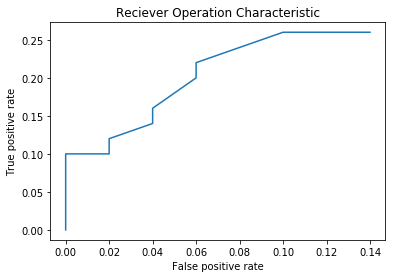

In [13]:
import numpy as np

print(fpr)  
print(tpr)

for i in range(len(threshold) - 1):
    fpr[i] = fpr[i]/(len(threshold)-1)
    tpr[i] = tpr[i]/(len(threshold)-1)

print(fpr)  
print(tpr)
plt.plot(fpr, tpr)
plt.title("Reciever Operation Characteristic")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')